# Installing requirements

In [1]:
dataset_path = 'dataset.json'
batch_dataset_path = 'batch_dataset.json'
seed = 0

In [2]:
!pip install huggingface_hub
!pip install datasets
!pip install scikit-learn
!pip install matplotlib

from pathlib import Path
from huggingface_hub import notebook_login
import datasets
import warnings
from tqdm import tqdm, TqdmWarning
warnings.filterwarnings('ignore', category = TqdmWarning)
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Download the dataset

In [3]:
if Path(dataset_path).exists() :
    dataset = pd.read_json(dataset_path)
else :
    notebook_login()
    hugging_face_dataset = datasets.load_dataset('lmsys/chatbot_arena_conversations')
    dataset = hugging_face_dataset['train'].to_pandas()
    dataset.to_json(dataset_path)

In [4]:
dataset[dataset['turn'] > 3][:1]

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
33,8120899314f74641b09c2aa114d4d253,alpaca-13b,vicuna-13b,model_b,arena_user_316,[{'content': 'Salut ! Comment ça va ce matin ?...,[{'content': 'Salut ! Comment ça va ce matin ?...,6,True,French,1.682354e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


# Create text-author pairs

In [5]:
# Initialize an empty list for processed data
text_author_pairs = []

# Iterate through each row of the DataFrame
for _, row in dataset.iterrows():
    # Process conversation_a (assistant role)
    for message in row["conversation_a"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_a"]
            })

    # Process conversation_b (assistant role)
    for message in row["conversation_b"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_b"]
            })

    # Process user messages (common across both conversations)
    for message in row["conversation_a"]:  # Check only `conversation_a` since user messages are identical
        if message["role"] == "user":
            text_author_pairs.append({
                "text": message["content"],
                "author": "human"
            })

# Create token count vectors for each text

In [6]:
# Extract texts and their authors
texts = [entry['text'] for entry in text_author_pairs]
authors = [entry['author'] for entry in text_author_pairs]

# Vectorize the paragraphs
vectoriser = CountVectorizer()
text_vectors = vectoriser.fit_transform(texts)  # Each row is a text

# Allocate quotas for each batch.
batch_count = {} 
for author in list(set(authors)) :
    # Find out how many batches of 200 texts are needed.
    number_of_batches = round(authors.count(author) / 200)
    for i in range(number_of_batches) :
        # Distribute the remainder/shortfall evenly.
        batch_count[str(i) + '_' + author] = np.floor((i + 1) * authors.count(author) / number_of_batches)
        for j in range(i) :
            # Subtract the count of previous batches.
            batch_count[str(i) + '_' + author] -= batch_count[str(j) + '_' + author]
        
print('Populating batches...')
batch_vectors = {}
batch_quota = batch_count.copy()
for i, author in enumerate(tqdm(authors)):
    batch_to_insert = [name for name in batch_quota if author in name and batch_quota[name] > 0][0]
    if batch_to_insert in batch_vectors:
        # The resulting vectors represent the number of times each token appears in that author's entire corpus.
        batch_vectors[batch_to_insert] += text_vectors[i].toarray()
    else:
        # Add this new batch to the list.
        batch_vectors[batch_to_insert] = text_vectors[i].toarray()
    batch_quota[batch_to_insert] -= 1

# Convert to a dataframe
print('Converting into DataFrame...')
batch_dataset = pd.DataFrame({name: vector.flatten() for name, vector in tqdm(batch_vectors.items())}, index = vectoriser.get_feature_names_out())

batch_dataset

Populating batches...


100%|█████████████████████████████████████████████████████████████████████████| 117948/117948 [02:22<00:00, 826.12it/s]


Converting into DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 1633.42it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0,0,0,0,8,3,1,0,1,3,...,0,0,0,3,0,0,0,0,0,2
000,3,1,0,4,0,2,4,0,0,0,...,0,0,3,6,0,3,0,7,2,0
0000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｔｏ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ｗｅｅｋｓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝗶𝗺𝗽𝗹𝗲,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Group texts by author

In [7]:
# Find the average text length of each author. 
batch_average_length = {name: np.sum(vector) / batch_count[name] for name, vector in batch_vectors.items()}

# Normalise the length of each corpus.
print('Normalising...')
for name in tqdm(batch_vectors) :
    batch_dataset[name] /= np.sum(batch_vectors[name])
    
# Since it has been lost, add the average text length as a separate feature.
batch_dataset = pd.concat([batch_dataset, pd.DataFrame(batch_average_length, index = [' length'])])

batch_dataset

Normalising...


100%|███████████████████████████████████████████████████████████████████████████████| 591/591 [00:01<00:00, 418.77it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.00,0.000,0.000000,0.000124,0.000,0.000000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.00,0.000,0.000619,0.000248,0.000,0.000157,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
batch_dataset.to_json(batch_dataset_path)

# Custom holdout

In [9]:
def holdout(df, authors) :
    holdout_list = []
    for author in authors :
        batch = df[random.choice([batch for batch in df.columns if author in batch])].copy()
        holdout_list.append(batch)

    holdout_df = pd.concat(holdout_list, axis = 1)
    training_df = df.drop(columns = holdout_df.columns).copy()
    return training_df, holdout_df

In [10]:
random.seed(seed)
training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)))

training_dataset

,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.00,0.000,0.000000,0.000124,0.000,0.000000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.00,0.000,0.000619,0.000248,0.000,0.000157,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000


# Feature selection

In [11]:
human_dataset = training_dataset[[name for name in training_dataset.columns if 'human' in name]].copy()
llm_dataset = training_dataset[[name for name in training_dataset.columns if not 'human' in name]].copy()
training_dataset = pd.merge(llm_dataset[llm_dataset.ne(0).sum(axis=1) == llm_dataset.shape[1]], human_dataset, left_index=True, right_index=True, validate='1:1')

training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,0.000698,0.000945,0.000705,0.000463,0.000630,0.000994,0.000687,0.001040,0.000472,0.000806,...,0.001238,0.000262,0.001459,0.001037,0.001772,0.001856,0.002592,0.001610,0.000227,0.000481
about,0.001776,0.001068,0.001309,0.000810,0.002116,0.001160,0.003070,0.002459,0.001769,0.002110,...,0.001856,0.003148,0.005209,0.005965,0.002658,0.005568,0.003672,0.004428,0.002496,0.001443
after,0.000317,0.000205,0.000554,0.000231,0.000180,0.000580,0.000404,0.000095,0.000708,0.000345,...,0.000619,0.000262,0.000417,0.000259,0.001624,0.000825,0.000864,0.005233,0.000227,0.000601
all,0.001237,0.001068,0.001107,0.001620,0.000856,0.000994,0.002101,0.001797,0.000708,0.001189,...,0.003249,0.001574,0.001459,0.002075,0.002805,0.002475,0.002592,0.002147,0.001815,0.000241
also,0.003075,0.002998,0.002718,0.004165,0.003062,0.002486,0.002747,0.002838,0.002713,0.003108,...,0.000309,0.001049,0.000417,0.000259,0.000886,0.000412,0.001080,0.001342,0.000908,0.000241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.000919,0.001027,0.000856,0.001620,0.001396,0.000994,0.001656,0.002459,0.001455,0.001650,...,0.000464,0.000787,0.000417,0.000259,0.000000,0.000825,0.001944,0.000000,0.000681,0.000361
would,0.000476,0.001930,0.001057,0.003008,0.001891,0.001740,0.002141,0.001419,0.001455,0.001919,...,0.001238,0.001049,0.003751,0.003112,0.002362,0.003300,0.001080,0.001476,0.002042,0.000722
you,0.009480,0.010103,0.012080,0.010066,0.008240,0.010108,0.013492,0.013432,0.008965,0.009247,...,0.008199,0.017576,0.012294,0.013485,0.005758,0.016498,0.013610,0.013149,0.010211,0.003007
your,0.003234,0.004271,0.006845,0.003587,0.004233,0.002900,0.004039,0.003689,0.003146,0.005986,...,0.001547,0.002099,0.003126,0.002334,0.002658,0.003300,0.006697,0.002549,0.003177,0.000962


# Centring

In [12]:
features_mean = pd.Series({feature: np.mean(training_dataset.loc[feature]) for feature in training_dataset.index})
for batch in training_dataset.columns :
    training_dataset[batch] -= features_mean

training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,-0.000756,-0.000509,-0.000749,-0.000991,-0.000823,-4.592571e-04,-0.000767,-0.000413,-0.000982,-0.000648,...,-0.000216,-0.001191,0.000005,-0.000416,0.000318,0.000403,0.001139,0.000157,-0.001227,-0.000972
about,-0.000573,-0.001281,-0.001040,-0.001539,-0.000233,-1.189115e-03,0.000721,0.000110,-0.000580,-0.000239,...,-0.000493,0.000799,0.002860,0.003616,0.000309,0.003219,0.001323,0.002079,0.000147,-0.000906
after,-0.000262,-0.000374,-0.000026,-0.000348,-0.000399,4.992515e-07,-0.000176,-0.000485,0.000128,-0.000234,...,0.000039,-0.000317,-0.000163,-0.000320,0.001045,0.000245,0.000285,0.004653,-0.000353,0.000022
all,-0.000360,-0.000528,-0.000489,0.000024,-0.000741,-6.018821e-04,0.000504,0.000201,-0.000888,-0.000407,...,0.001653,-0.000022,-0.000137,0.000479,0.001209,0.000879,0.000996,0.000551,0.000219,-0.001356
also,0.001375,0.001298,0.001018,0.002465,0.001362,7.852532e-04,0.001047,0.001137,0.001013,0.001408,...,-0.001391,-0.000651,-0.001283,-0.001441,-0.000814,-0.001288,-0.000620,-0.000359,-0.000793,-0.001460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,-0.000125,-0.000018,-0.000189,0.000575,0.000351,-5.069873e-05,0.000611,0.001414,0.000410,0.000605,...,-0.000581,-0.000258,-0.000628,-0.000786,-0.001045,-0.000220,0.000899,-0.001045,-0.000364,-0.000684
would,-0.001307,0.000147,-0.000726,0.001225,0.000108,-4.322563e-05,0.000358,-0.000364,-0.000328,0.000135,...,-0.000545,-0.000734,0.001968,0.001329,0.000579,0.001517,-0.000703,-0.000307,0.000259,-0.001061
you,-0.001251,-0.000628,0.001348,-0.000666,-0.002492,-6.237443e-04,0.002760,0.002700,-0.001766,-0.001484,...,-0.002532,0.006845,0.001563,0.002754,-0.004973,0.005767,0.002878,0.002418,-0.000520,-0.007724
your,-0.001029,0.000008,0.002582,-0.000677,-0.000031,-1.363486e-03,-0.000224,-0.000574,-0.001117,0.001722,...,-0.002716,-0.002165,-0.001138,-0.001929,-0.001606,-0.000964,0.002434,-0.001714,-0.001086,-0.003301


# Standardisation

In [13]:
features_std = pd.Series({feature: np.std(training_dataset.loc[feature]) for feature in training_dataset.index})
for batch in training_dataset.columns :
    training_dataset[batch] /= features_std

training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,-0.476786,-0.320952,-0.472293,-0.624834,-0.519141,-0.289666,-0.483614,-0.260474,-0.619118,-0.408514,...,-0.136132,-0.751278,0.003267,-0.262454,0.200750,0.253928,0.718333,0.098792,-0.773616,-0.613283
about,-0.405675,-0.906298,-0.735939,-1.088731,-0.164647,-0.841152,0.509981,0.078031,-0.409940,-0.168825,...,-0.348440,0.565150,2.023381,2.557670,0.218293,2.277144,0.936201,1.470445,0.103994,-0.640647
after,-0.522175,-0.744483,-0.051337,-0.692635,-0.794712,0.000994,-0.349270,-0.964896,0.255415,-0.465911,...,0.078330,-0.631086,-0.323775,-0.637043,2.078890,0.488479,0.566499,9.260358,-0.701569,0.043670
all,-0.393675,-0.578403,-0.535152,0.025977,-0.810844,-0.658992,0.552281,0.220201,-0.972571,-0.445193,...,1.809496,-0.024203,-0.150487,0.524019,1.323907,0.962027,1.090802,0.602958,0.240011,-1.484145
also,1.447642,1.366176,1.071291,2.594799,1.433286,0.826611,1.101682,1.197344,1.066328,1.481868,...,-1.464096,-0.685214,-1.351094,-1.516803,-0.857270,-1.355618,-0.652761,-0.377389,-0.834346,-1.536570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,-0.194716,-0.028196,-0.293788,0.892469,0.544774,-0.078703,0.948907,2.195710,0.636498,0.939201,...,-0.901600,-0.400372,-0.975113,-1.219482,-1.622067,-0.341500,1.396145,-1.622067,-0.565316,-1.061915
would,-1.368253,0.154028,-0.759845,1.282074,0.113070,-0.045234,0.374448,-0.381161,-0.343410,0.141719,...,-0.570802,-0.767859,2.059150,1.390718,0.606164,1.587053,-0.735597,-0.321435,0.271172,-1.110729
you,-0.313500,-0.157415,0.337763,-0.166718,-0.624169,-0.156257,0.691478,0.676454,-0.442413,-0.371832,...,-0.634352,1.714680,0.391499,0.689925,-1.245883,1.444668,0.721082,0.605649,-0.130373,-1.935095
your,-0.505268,0.003920,1.267499,-0.332110,-0.015080,-0.669348,-0.109872,-0.281903,-0.548576,0.845586,...,-1.333411,-1.062623,-0.558451,-0.947068,-0.788217,-0.473034,1.194713,-0.841383,-0.533360,-1.620494


C:\Users\rickc\AppData\Local\Temp\ipykernel_20220\1364267143.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  feature_graph_figure.show()


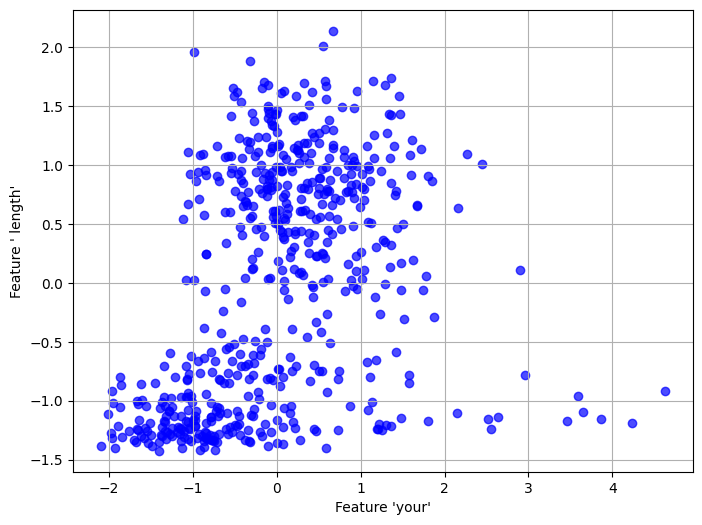

In [14]:
# Extracting the two features
x_token = training_dataset.index[-2]
y_token = training_dataset.index[-1]

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter(training_dataset.loc[x_token], training_dataset.loc[y_token], color='blue', alpha=0.7)
feature_graph.set_xlabel("Feature '" + x_token + "'")
feature_graph.set_ylabel("Feature '" + y_token + "'")
feature_graph.grid(True)
feature_graph_figure.show()

In [15]:
def power_iteration(A, num_iter=1000, tol=1e-6):
    """
    Power Iteration to compute the largest eigenvector of matrix A.
    Args:
        A (np.ndarray): Input symmetric matrix.
        num_iter (int): Number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        eigenvector (np.ndarray): Approximation of the largest eigenvector.
        eigenvalue (float): Corresponding eigenvalue.
    """
    b = np.random.rand(A.shape[1])  # Random initial vector
    b = b / np.linalg.norm(b)

    error_meter = tqdm(position = 0, total=6, bar_format='{bar} | {postfix}')
    for i in range(num_iter):
        b_next = A @ b  # Matrix-vector multiplication
        b_next = b_next / np.linalg.norm(b_next)  # Normalize
        
        # Check for convergence
        error = np.linalg.norm(b_next - b)
        b = b_next
        error_meter.update(min(-np.log10(error), error_meter.total) - error_meter.n)
        error_meter.set_postfix_str('{:.2E}'.format(error) + ' of error after ' + str(i + 1) + ' iterations...')
        if error < tol:
            error_meter.close()
            break

    eigenvalue = b.T @ A @ b  # Rayleigh quotient for eigenvalue
    return b, eigenvalue

In [16]:
def pca_power_iteration(data, num_components, num_iter=2000):
    """
    PCA using Power Iteration to compute the principal components.
    Args:
        data (np.ndarray): Input data matrix (rows are samples, columns are features).
        num_components (int): Number of principal components to compute.
        num_iter (int): Number of iterations for power iteration.

    Returns:
        components (list): List of principal components (eigenvectors).
        explained_variance (list): List of corresponding eigenvalues.
    """
    # Step 1: Center the data
    covariance_matrix = np.cov(data, rowvar=True, ddof = 0)
    
    # Compute covariance matrix manually
    n = data.shape[1]  # Number of samples (columns in your case)
    covariance_matrix = (data @ data.T) / n

    components = []
    explained_variance = []

    for i in range(num_components):
        # Step 2: Compute the largest eigenvector using power iteration
        print('Extracting PC' + str(i + 1) + '...')
        eigenvector, eigenvalue = power_iteration(covariance_matrix, num_iter=num_iter)
        components.append(eigenvector)
        explained_variance.append(eigenvalue)
        
        # Step 3: Deflate the covariance matrix
        covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
        if np.linalg.norm(covariance_matrix, ord='fro') < 1e-10 :
            print('Stopped as all variance has been extracted after computing ' + str(i + 1) + ' PCs.')
            break
        
    return components, explained_variance

In [17]:
components, explained_variance = pca_power_iteration(training_dataset, num_components=50)

Extracting PC1...


██████████████████████████████████████████████████████████████████████████ | , 3.68E-07 of error after 14 iterations...


Extracting PC2...


██████████████████████████████████████████████████████████████████████████ | , 8.70E-07 of error after 40 iterations...


Extracting PC3...


██████████████████████████████████████████████████████████████████████████ | , 7.39E-07 of error after 34 iterations...


Extracting PC4...


█████████████████████████████████████████████████████████████████████████ | , 9.50E-07 of error after 172 iterations...


Extracting PC5...


█████████████████████████████████████████████████████████████████████████ | , 9.43E-07 of error after 205 iterations...


Extracting PC6...


█████████████████████████████████████████████████████████████████████████ | , 9.46E-07 of error after 111 iterations...


Extracting PC7...


█████████████████████████████████████████████████████████████████████████ | , 9.76E-07 of error after 305 iterations...


Extracting PC8...


█████████████████████████████████████████████████████████████████████████ | , 9.57E-07 of error after 160 iterations...


Extracting PC9...


█████████████████████████████████████████████████████████████████████████ | , 9.66E-07 of error after 267 iterations...


Extracting PC10...


█████████████████████████████████████████████████████████████████████████ | , 9.57E-07 of error after 234 iterations...


Extracting PC11...


█████████████████████████████████████████████████████████████████████████ | , 9.51E-07 of error after 134 iterations...


Extracting PC12...


█████████████████████████████████████████████████████████████████████████ | , 9.77E-07 of error after 167 iterations...


Extracting PC13...


████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 1494 iterations...


Extracting PC14...


█████████████████████████████████████████████████████████████████████████ | , 9.60E-07 of error after 251 iterations...


Extracting PC15...


█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 696 iterations...


Extracting PC16...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-07 of error after 447 iterations...


Extracting PC17...


█████████████████████████████████████████████████████████████████████████ | , 9.88E-07 of error after 452 iterations...


Extracting PC18...


█████████████████████████████████████████████████████████████████████████ | , 9.87E-07 of error after 315 iterations...


Extracting PC19...


█████████████████████████████████████████████████████████████████████████ | , 9.37E-07 of error after 169 iterations...


Extracting PC20...


█████████████████████████████████████████████████████████████████████████ | , 9.85E-07 of error after 565 iterations...


Extracting PC21...


█████████████████████████████████████████████████████████████████████████ | , 9.79E-07 of error after 387 iterations...


Extracting PC22...


█████████████████████████████████████████████████████████████████████████ | , 9.87E-07 of error after 275 iterations...


Extracting PC23...


█████████████████████████████████████████████████████████████████████████ | , 9.83E-07 of error after 495 iterations...


Extracting PC24...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-07 of error after 653 iterations...


Extracting PC25...


█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 989 iterations...


Extracting PC26...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-07 of error after 488 iterations...


Extracting PC27...


█████████████████████████████████████████████████████████████████████████ | , 9.70E-07 of error after 197 iterations...


Extracting PC28...


██████████████████████████████████████████████████████████████████████▎  | , 1.37E-06 of error after 2000 iterations...


Extracting PC29...


█████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 529 iterations...


Extracting PC30...


█████████████████████████████████████████████████████████████████████████ | , 9.78E-07 of error after 391 iterations...


Extracting PC31...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-07 of error after 399 iterations...


Extracting PC32...


█████████████████████████████████████████████████████████████████████████ | , 9.98E-07 of error after 692 iterations...


Extracting PC33...


█████████████████████████████████████████████████████████████████████████ | , 9.84E-07 of error after 483 iterations...


Extracting PC34...


█████████████████████████████████████████████████████████████████████████ | , 9.74E-07 of error after 291 iterations...


Extracting PC35...


██████████████████████████████████████████████▉                          | , 1.24E-04 of error after 2000 iterations...


Extracting PC36...


█████████████████████████████████████████████████████████████████████████ | , 9.60E-07 of error after 236 iterations...


Extracting PC37...


████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 1200 iterations...


Extracting PC38...


█████████████████████████████████████████████████████████████████████████ | , 9.96E-07 of error after 466 iterations...


Extracting PC39...


████████████████████████████████████████████████████████████████████████ | , 9.96E-07 of error after 1093 iterations...


Extracting PC40...


█████████████████████████████████████████████████████████████████████████ | , 9.88E-07 of error after 717 iterations...


Extracting PC41...


████████████████████████████████████████████████████████████████████████ | , 1.00E-06 of error after 1137 iterations...


Extracting PC42...


█████████████████████████████████████████████████████████████████████████ | , 9.74E-07 of error after 315 iterations...


Extracting PC43...


████████████████████████████████████████████████████████████████████████ | , 9.98E-07 of error after 1144 iterations...


Extracting PC44...


█████████████████████████████████████████████████████████████████████████ | , 9.93E-07 of error after 286 iterations...


Extracting PC45...


████████████████████████████████████████████████████████████████████████ | , 9.98E-07 of error after 1944 iterations...


Extracting PC46...


█████████████████████████████████████████████████████████████████████████ | , 9.70E-07 of error after 263 iterations...


Extracting PC47...


████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 1459 iterations...


Extracting PC48...


█████████████████████████████████████████████████████████████████████████ | , 9.85E-07 of error after 627 iterations...


Extracting PC49...


█████████████████████████████████████████████████████████████████████████ | , 9.80E-07 of error after 525 iterations...


Extracting PC50...


█████████████████████████████████████████████████████████████████████████ | , 9.97E-07 of error after 858 iterations...


In [18]:
print(len(explained_variance))
for variance in range(len(explained_variance)) :
    print(np.sum(explained_variance[:variance + 1]))
print(len(components[0]))
print(np.sum([np.std(training_dataset.loc[feature]) for feature in training_dataset.index]))

50
18.83719289259459
24.743501743261238
29.145506400026964
32.213045042236296
35.09108989861548
37.79346594530073
40.265521994170186
42.65335573910971
44.90768444137279
47.05324841366427
49.100764343711845
51.00098048356085
52.77046878693835
54.53145852347757
56.20803603894656
57.86479207837261
59.48180534864464
61.0628339758374
62.599910079452094
64.05600286795737
65.48856894289227
66.88912205459722
68.2431780086846
69.5686118967661
70.87992724278199
72.18275839533041
73.45813775577285
74.66904415591372
75.87461429052513
77.05836497210653
78.2075900291139
79.3280881801935
80.43336831087782
81.51467886941582
82.56460766352117
83.61486854291847
84.6115784304768
85.59941902965724
86.5615381665214
87.51395151551672
88.45280453492546
89.3840608564745
90.2879663222857
91.18592207932906
92.0507566245221
92.91083530710088
93.73570334355306
94.55530640146017
95.36204201686789
96.15185096930959
123
123.0


C:\Users\rickc\AppData\Local\Temp\ipykernel_20220\2754971945.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  feature_graph_figure.show()


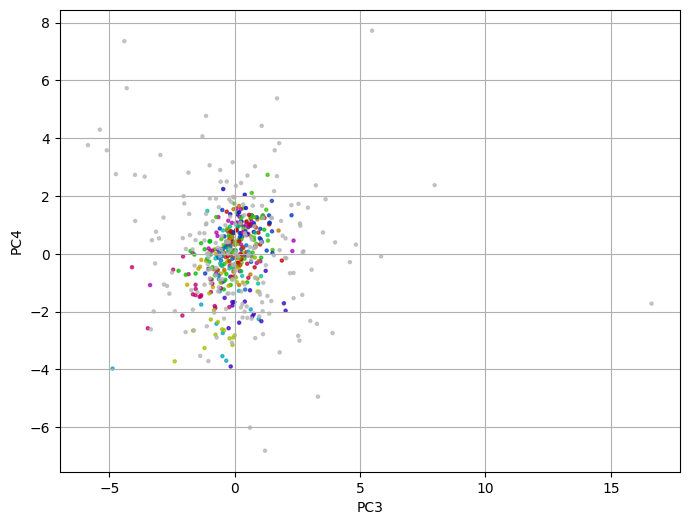

In [19]:
# Define a colour for each author.
colour_list = {author: colors.hsv_to_rgb((i / len(set(authors)), 1, 0.75)) for i, author in enumerate(list(set(authors)))}
colour_list['human'] = colors.hsv_to_rgb((0, 0, 0.7))

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
coords = [[np.dot(training_dataset[batch], components[6]), np.dot(training_dataset[batch], components[7])] for batch in training_dataset]
feature_graph.scatter([coord[0] for coord in coords], [coord[1] for coord in coords], color=[colour_list[batch.split('_')[1]] for batch in training_dataset], s = 5, alpha=0.7)
#for author in list(set(authors)):
#    feature_graph.annotate(author, coords[training_dataset.columns.get_loc('0_' + author)])
feature_graph.set_xlabel("PC3")
feature_graph.set_ylabel("PC4")
feature_graph.grid(True)
feature_graph_figure.show()

In [20]:
ranking = np.argsort(components[0])
dimensions = training_dataset.index[ranking]
weights = components[0][ranking]
for i in range(len(dimensions)) :
    print(dimensions[i] + ' ' + str(weights[i]))

what -0.19495580007674607
me -0.18702840039993543
how -0.18205033501542042
do -0.16067880682503177
about -0.1388388053014994
my -0.12346147352076965
should -0.10579251355606131
an -0.090850804001833
who -0.08142949798159685
one -0.07263432665098969
at -0.07008800833754758
no -0.06472691450690499
all -0.06459162764975597
like -0.06027238682692836
when -0.05988081438426096
know -0.059738415521978346
after -0.057301372842921965
first -0.0547809931758662
10 -0.05407010688234752
many -0.05303985936728799
best -0.05285530560290012
you -0.05070395868991041
would -0.0502476734689617
two -0.04877343641125084
where -0.04828077900317451
out -0.04761539046004095
don -0.04627518042882642
in -0.04479438982521102
just -0.043094457512166166
from -0.042558778281742045
without -0.03923277575764093
then -0.03865816512136735
get -0.038120645531556925
same -0.03721142402519749
each -0.03600345191607114
if -0.03446060168809441
most -0.03191550388753726
between -0.03095163424530724
into -0.029612908500804943

C:\Users\rickc\AppData\Local\Temp\ipykernel_20220\1250825411.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  weights = components[0][ranking]
C:\Users\rickc\AppData\Local\Temp\ipykernel_20220\1250825411.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(dimensions[i] + ' ' + str(weights[i]))


# k-Nearest Neighbours

In [21]:
def transform_to_pc(batch, components, mean = None, std = None) :
    normalised_batch = batch.copy()
    if not mean is None :
        normalised_batch -= mean
        normalised_batch /= std
        
    pc_space_batch = []
    for component in components :
        pc_space_batch.append(np.dot(normalised_batch, component))
        
    return pc_space_batch

In [22]:
def k_nearest_neighbours(X_train, y_train, X_test, y_test, k = 3):
    """
    Predict labels for the test dataset.
    """
    predictions = []

    for test_point in X_test:
        # Compute distances to all training points
        distances = np.linalg.norm(X_train - test_point, axis=1)
        
        # Find indices of k nearest neighbors
        k_indices = np.argsort(distances)[k]
        
        # Retrieve the labels of the k nearest neighbors
        k_labels = y_train[k_indices]
        
        # Determine the most common label (majority voting)
        unique_labels, counts = np.unique(k_labels, return_counts=True)
        predictions.append(unique_labels[np.argmax(counts)])
    
    return np.array(predictions)

In [23]:
holdout_dataset['3_guanaco-33b']

KeyError: '3_guanaco-33b'

In [29]:
training_batches = [transform_to_pc(training_dataset[batch], components[:10]) for batch in training_dataset]
training_labels = [batch.split('_')[1] for batch in training_dataset]
holdout_dataset = holdout_dataset.loc[training_dataset.index].copy()
testing_batches = [transform_to_pc(holdout_dataset[batch], components[:10], features_mean, features_std) for batch in holdout_dataset]
testing_labels = [batch.split('_')[1] for batch in holdout_dataset]

# predictions = k_nearest_neighbours(training_dataset, holdout_dataset, 3)

# # Visualization example:
# plt.figure(figsize=(8, 6))
# plt.scatter(holdout_dataset.T[:, 0], holdout_dataset.T[:, 1], c=predictions, cmap='viridis', label='Predictions')
# plt.scatter(training_dataset.T[:, 0], training_dataset.T[:, 1], c=training_labels, alpha=0.3, cmap='viridis', label='Training Data')
# plt.xlabel('PCA1')
# plt.ylabel('PCA2')
# plt.legend()
# plt.title('k-NN Classification with PCA-transformed Data')
# plt.show()

testing_batches

[[np.float64(4.3097216813322055),
  np.float64(1.1269513981338526),
  np.float64(0.425440598051634),
  np.float64(-2.6366758220402517),
  np.float64(-1.049620171117925),
  np.float64(1.4258732027001462),
  np.float64(1.6439597094688283),
  np.float64(0.5294097960455467),
  np.float64(-0.6465280168072604),
  np.float64(0.7922002759189106)],
 [np.float64(1.8941170859792662),
  np.float64(-4.093885052971329),
  np.float64(0.10778856292748662),
  np.float64(-0.20192522605678156),
  np.float64(1.4812587708654894),
  np.float64(1.9547571355779825),
  np.float64(-0.9097583801576498),
  np.float64(-0.11376350495688951),
  np.float64(1.2985195251970714),
  np.float64(0.3628777047127421)],
 [np.float64(2.4195846256649154),
  np.float64(0.36245775048699325),
  np.float64(0.05360819638448232),
  np.float64(-1.668356938257674),
  np.float64(-0.2773390561672255),
  np.float64(0.023511134685490962),
  np.float64(-0.5806243889997754),
  np.float64(0.19900666143714427),
  np.float64(0.16833537565472975

In [30]:
holdout_dataset

,12_vicuna-7b,24_gpt-4,13_mpt-7b-chat,1_claude-v1,8_palm-2,16_gpt-3.5-turbo,31_koala-13b,12_oasst-pythia-12b,2_guanaco-33b,3_wizardlm-13b,...,9_llama-13b,6_claude-instant-v1,32_vicuna-13b,4_stablelm-tuned-alpha-7b,9_dolly-v2-12b,35_human,3_chatglm-6b,8_fastchat-t5-3b,17_alpaca-13b,5_gpt4all-13b-snoozy
10,0.000399,0.000829,0.001138,0.001312,0.000761,0.001353,0.000489,0.000627,0.001139,0.001307,...,0.002438,0.000881,0.000944,0.001357,0.001352,0.001871,0.001524,0.001945,0.001535,0.000854
about,0.001906,0.001154,0.002106,0.002197,0.002253,0.001403,0.001502,0.001496,0.001653,0.002381,...,0.002045,0.001290,0.001259,0.001809,0.000966,0.001531,0.002018,0.001945,0.000959,0.002278
after,0.000443,0.000325,0.000171,0.000732,0.000822,0.000351,0.000699,0.000289,0.000478,0.000140,...,0.000236,0.000566,0.000472,0.000407,0.000097,0.002041,0.000330,0.000195,0.000480,0.000570
all,0.003635,0.001118,0.001537,0.001525,0.002284,0.000852,0.001956,0.001689,0.000772,0.001074,...,0.005820,0.001951,0.001141,0.001673,0.001738,0.003061,0.001318,0.001119,0.000767,0.001538
also,0.001596,0.001082,0.001935,0.001769,0.004293,0.001904,0.002795,0.002026,0.002903,0.001587,...,0.001494,0.001038,0.003069,0.002216,0.001738,0.000850,0.002883,0.002529,0.001535,0.003133
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.000621,0.000757,0.000683,0.000702,0.001766,0.001052,0.002201,0.000579,0.001359,0.000513,...,0.002674,0.000472,0.000905,0.001312,0.001641,0.001361,0.001442,0.001313,0.000863,0.000456
would,0.000931,0.001406,0.002163,0.002898,0.001614,0.000802,0.001258,0.001544,0.001947,0.001540,...,0.003696,0.003147,0.001102,0.001673,0.002221,0.001871,0.001442,0.001508,0.002302,0.002506
you,0.011791,0.007608,0.010301,0.007230,0.013762,0.009121,0.008943,0.008298,0.010876,0.007469,...,0.009202,0.008905,0.007044,0.011261,0.008304,0.013435,0.010709,0.008705,0.011416,0.013955
your,0.007536,0.005986,0.004667,0.003325,0.005755,0.005413,0.004890,0.004487,0.004005,0.005928,...,0.003303,0.004500,0.004093,0.006693,0.003862,0.004422,0.003995,0.002626,0.004221,0.007860
